# Problem Set 3 

This Problem Set continues the $CakeEating$ model, but with parameters $\beta$ and $\gamma$ to be estimated associated with data on 3000 individuals. 

First, import tools needed.

In [477]:
import pandas as pd
import os
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d, interp2d
from scipy.optimize import minimize_scalar,minimize
import matplotlib.pyplot as plt
%matplotlib inline
from quantecon.markov import DiscreteDP
from scipy.stats import norm
from math import sqrt
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.optimize import brentq
import time

## Choose auxiliary model and compute weight matrix

I choose auxiliary models as 19 moments: mean of consumption at each age and mean of assets at each age. Since there are 10 periods, there should be 20 moments. The first period asset is 0, so I simply exclude it. Thus there are 19 moments in my auxiliary model. <br /> 

The reason why I choose the first order moments is simple: The utility function is CRRA, which means the preference is homothetic. Each agent has the same homothetic preference, which means their consumption can be aggregated. The economy admits a representative agent, so I can just see the mean of consumption and mean of asset to treat it as a reuslt of a single agent's optimization. 

In [243]:
df = pd.read_csv('Pset3Data.csv')
#df.head()

Set initial values based on the data

In [259]:
np.random.seed(123456)
T = np.max(df.age)
N = np.max(df.id) # the number of individuals
nb = 100 # the number of draws for bootstrap. 

Bootstrap to calculate moments: average consumption and average assets.

In [24]:
c_mean = np.zeros((T, nb))
a_mean = np.zeros((T, nb))
for k in range(nb):
    draw = np.random.choice(N, N, replace = True)
    df_draw = df[df.id==draw[0]]
    for i in range(1,N):
        df_draw = df_draw.append(df[df.id==draw[i]])
    for t in range(T):
        age = t+1
        c_mean[t,k] = df_draw.cons[df_draw.age == age].mean()
        a_mean[t,k] = df_draw.asset[df_draw.age == age].mean()

In [81]:
bmoments = np.vstack([c_mean,a_mean])   # bmoments now is 20 by 100

Compute data moments

In [478]:
c_mean_data = np.zeros((T,1))
a_mean_data = np.zeros((T,1))
for t in range(T):
    age = t+1
    c_mean_data[t] = df.cons[df.age == age].mean()
    a_mean_data[t] = df.asset[df.age == age].mean()

In [633]:
data_moments = np.vstack([c_mean_data,a_mean_data]) # data_moments now is 20 by 1 , the first 10  moments is for c, and the remaining is for a.

In [634]:
# repeat data moments for 100 times.
data_moments = np.repeat(data_moments, nb,axis=1)  # data_moments now is 20 by 100

In [635]:
dbmoments = np.subtract(bmoments,data_moments)

In [483]:
variance = np.mean(dbmoments**2,axis = 1)    # variance is 1 by 20.
variance = np.delete(variance,10)

In [484]:
dataMomentsVCM = np.identity(2*T-1)

In [485]:
np.fill_diagonal(dataMomentsVCM, variance)     # dataMomentsVCM is a matrix of 20 by 20 

In [486]:
WeightMatrix = np.linalg.inv(dataMomentsVCM)    # take inverse 

## Write the model

The model is the same as what has been done for the last problem set. 

In [696]:
class CakeEating:
    def __init__(self, 
                 T = 10, 
                 r = 0.03,  
                 a0 = 0, 
                 minCons = 1e-5, 
                 ρ = 0.4, 
                 σ = 1,
                 N_inc = 3,       # number of income grid
                 N_grid = 3,   # number of asset grid
                 μ = 0):
        self.T, self.r, self.a0, self.minCons, self.ρ, self.σ, self.N_inc, self.N_grid, self.μ = T, r, a0, minCons, ρ, σ, N_inc, N_grid,μ    
        
    def Grid(self,y_max,y_min,N_grid):
        T,r,a0,minCons = self.T,self.r,self.a0,self.minCons
        
        gridMax = np.zeros(T)
        gridMax[0] = a0
        for num in range(T-1):
            gridMax[num+1]=(gridMax[num] + y_max)*(1+r)
        
        gridMin = np.zeros(T)
        gridMin[T-1] = -y_min + minCons
        for t in range(T-1):
            age = T-t-1
            gridMin[age-1] = gridMin[age]/(1+r) - y_min + minCons
        #for num in range(T):
         #   gridMin[num] = - y_min*(1/(1+r)-(1/(1+r))**(T-num+1))/(1-1/(1+r)) 
        
        loggrid = np.zeros((T,N_grid)) 
        grid = np.zeros((T,N_grid))
        for num in range(T):
            span = gridMax[num] - gridMin[num]
            loggrid[num,:] = np.linspace((np.log(1)),(np.log(1+span)),N_grid)
            grid[num,:] = np.exp(loggrid[num,:]) - 1 + gridMin[num]
        
        return(grid)
    
    def Utility(self,c,γ):
        return(c**(1-γ)/(1-γ))
    
    def MU(self,c,γ):
        return(c**(-γ))
    
    #generate a transition matrix
    def Pi(self):
        σ, ρ, N_inc, μ = self.σ,self.ρ,self.N_inc,self.μ
        sig_epsilon = σ/sqrt(1-ρ**2)    # SD of income
        
        #generate grid points epsilon
        epsilon = []
        epsilon.append(-3*sig_epsilon)
        n = list(range(2,N_inc+1))
        
        for num in n:
            epsilon.append(sig_epsilon*norm.ppf((num-1)/N_inc)+μ)

        epsilon.append(3*sig_epsilon)  #generate epsilon 
        
        #generate z_i
        z=[]
        for i in range(0,N_inc):
            z.append(N_inc*sig_epsilon*(norm.pdf((epsilon[i]-μ)/sig_epsilon)-norm.pdf((epsilon[i+1]-μ)/sig_epsilon)) + μ)
        
        #generate transition matrix
        Pi = np.zeros(shape=(N_inc,N_inc))
        for i in range(0,N_inc):
            for j in range(0,N_inc):
                Pi[i,j] = norm.cdf((epsilon[j+1]-μ*(1-ρ)-ρ*(epsilon[i+1]))/σ) - norm.cdf((epsilon[j]-μ*(1-ρ)-ρ*(epsilon[i+1]))/σ)
        
        sum = Pi.sum(axis=1)
        
        #normalize
        for i in range(0,N_inc):
            for j in range(0,N_inc):
                Pi[i,j] = Pi[i,j]/sum[i]  
        
        
        return Pi, z
    

In [697]:
model = CakeEating()
Pi,z = model.Pi()
y = np.exp(z)
T,r,N_inc,N_grid = model.T,model.r,model.N_inc,N_grid
a_grid = model.Grid(max(y),min(y),N_grid)
MU = model.MU

In [698]:
c_matrix = []
for j in range(N_grid):
    c_matrix.append(a_grid[T-1]+y[j]) 
c = np.zeros((T,N_grid,N_inc))
for j in range(N_inc):
    for i in range(N_grid):
        c[T-1,i,j] = c_matrix[j][i] 

In [699]:
def Euler_linear(a0,index,a1,β,γ,f):
    ConsumptionToday = a0 + y[index] - a1/(1+r)
    w = Pi[index]
    data = np.zeros(N_inc)
    for i in range(N_inc):
        data[i] = (f(y[i],a1))**(-γ)
    #data = np.concatenate((MU2(y[0],a1),MU2(y[1],a1),MU2(y[2],a1),MU2(y[3],a1),MU2(y[4],a1)),axis = None)
    ExpectedMU = np.average(data, weights = w)
    Euler = MU(ConsumptionToday,γ) - (1+r)*β*ExpectedMU
    return Euler

In [700]:
def Euler_linear_cons(β,γ):
    c_Euler_linear = np.zeros((T,N_grid,N_inc))
    c_Euler_linear[T-1] = c[T-1]
    optimal_a_linear = np.zeros((T,N_grid,N_inc))
    for t in range(T-1):
        lb = np.min(a_grid[T-t-1])
        yy, aa = np.meshgrid(y, a_grid[T-t-1])
        MU2_linear = interp2d(y,a_grid[T-t-1],(MU(c_Euler_linear[T-t-1],γ))**(-1/γ))
        for i in range(N_grid):
            for j in range(N_inc):
                ub = (1+r)*(a_grid[T-t-2,i]+y[j]-1e-5) 
                diff = ub - lb
                if diff < 1e-5 or Euler_linear(a_grid[T-t-2,i],j,lb,β,γ,MU2_linear) > 0:  # if constrained
                    optimal_a_linear[T-t-1,i,j] = lb
                    c_Euler_linear[T-t-2,i,j] = a_grid[T-t-2,i] + y[j] - optimal_a_linear[T-t-1,i,j]/(1+r)
                else:
                    optimal_a_linear[T-t-1,i,j] = optimize.brentq(lambda a1: Euler_linear(a_grid[T-t-2,i],j,a1,β,γ,MU2_linear),lb,ub)
                    c_Euler_linear[T-t-2,i,j] = a_grid[T-t-2,i] + y[j] - optimal_a_linear[T-t-1,i,j]/(1+r)
    return(c_Euler_linear)

## Estimate unknown structural parameters

The objective function is as follows:
\begin{align}
\min_{\theta} (\tilde{\gamma}(\theta)-\hat{\gamma})'\hat{W}(\tilde{\gamma}(\theta)-\hat{\gamma})
\end{align}
where $\theta$ is a vector including $\beta$ and $\gamma$, which are parameters we want to estimate; and $\tilde{\gamma}$ is the moments from the simulation and $\hat{\gamma}$ is the moments calculated from the data.

In [701]:
def findMomentVec(θ):
    
    β, γ = θ[0], θ[1]
    
    c_Euler_linear = Euler_linear_cons(β,γ)
    
    np.random.seed(123456)
    num_ind = 3000
    state = np.zeros((num_ind,T))

    for i in range(num_ind):
        state[i,0] = np.random.choice(range(N_inc), 1, replace = True)
        
        for t in range(1,T):
            p=[]
            for j in range(N_inc):
                p.append(Pi[int(state[i,t-1]),j])  #int is to convert the float to integer
            
            state[i,t] = np.random.choice(range(N_inc),1,replace=True,p=p)
    
    cons = np.zeros([num_ind,T])
    a1 = np.zeros([num_ind,T])
    y_t = np.zeros([num_ind,T])
    a0 = model.a0

    for t in range(T):
        a = a_grid[t]
        yy, aa = np.meshgrid(y,a)
        consumption = interp2d(y,a,c_Euler_linear[t])   
        for i in range(num_ind):
            index = int(state[i,t])
            y_t[i,t] = y[index]
            if t == 0:
                cons[i,t] = consumption(y_t[i,t],a0)
                a1[i,t] = (a0 + y_t[i,t] - cons[i,t])*(1+r)
            else:
                cons[i,t] = consumption(y_t[i,t],a1[i,t-1])
                a1[i,t] = (a1[i,t-1] + y_t[i,t]- cons[i,t])*(1+r)
    
    a_start = np.zeros([num_ind,T])
    a_start[:,0]=a0
    a_start[:,1:]=a1[:,:-1]
    
    c_mean = np.zeros(T)
    a_mean = np.zeros(T)
    for t in range(T):
        c_mean[t] = np.average(cons[:,t])
        a_mean[t] = np.average(a_start[:,t])
        
    gamma_hat = np.concatenate((c_mean, a_mean[1:]), axis=None)
    data_moments_firstColu = data_moments[:,0]
    data_moments_delete = np.delete(data_moments_firstColu,10)
    diff = gamma_hat - data_moments_delete
    return(diff)

In [702]:
def getCriterionFunction(θ):
    diff = findMomentVec(θ)
    criterionFunction = diff@WeightMatrix@diff.T
    return (criterionFunction)

Set the initial values and bounds for optimization.

In [703]:
θ0 = np.array([0.9,1.5])  #set initial value
bnd = ((0,1), (1.1,10))    # set bound for beta and gamma
oout = minimize(getCriterionFunction,θ0,bounds=bnd)

In [704]:
oout

      fun: 2408.5417140780346
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.00477485, 0.00027285])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 57
      nit: 13
   status: 0
  success: True
        x: array([0.90636098, 6.79831391])

Extract the results

In [706]:
β_star = oout.x[0]
γ_star = oout.x[1]
θ_star = oout.x
θ_star

array([0.90636098, 6.79831391])

So the estimated $\hat{\beta}$ is 0.906 while $\hat{\gamma}$ is 6.80.

## Model fit

Plug the estimated parameters into the model. Simulate 3000 individuals and compute the simulated moments.

In [621]:
c_Euler_linear = Euler_linear_cons(β_star,γ_star)
    
np.random.seed(123456)
num_ind = 3000
state = np.zeros((num_ind,T))

for i in range(num_ind):
    state[i,0] = np.random.choice(range(N_inc), 1, replace = True)
        
    for t in range(1,T):
        p=[]
        for j in range(N_inc):
            p.append(Pi[int(state[i,t-1]),j])  #int is to convert the float to integer
            
        state[i,t] = np.random.choice(range(N_inc),1,replace=True,p=p)
        
a0 = model.a0 
cons = np.zeros([num_ind,T])
a1 = np.zeros([num_ind,T])
y_t = np.zeros([num_ind,T])


for t in range(T):
    a = a_grid[t]
    yy, aa = np.meshgrid(y,a)
    consumption = interp2d(y,a,c_Euler_linear[t])   
    for i in range(num_ind):
        index = int(state[i,t])
        y_t[i,t] = y[index]
        if t == 0:
            cons[i,t] = consumption(y_t[i,t],a0)
            a1[i,t] = (a0 + y_t[i,t] - cons[i,t])*(1+r)
        else:
            cons[i,t] = consumption(y_t[i,t],a1[i,t-1])
            a1[i,t] = (a1[i,t-1] + y_t[i,t]- cons[i,t])*(1+r)
             
            
a_start = np.zeros([num_ind,T])
a_start[:,0]=a0
a_start[:,1:]=a1[:,:-1]
c_mean = np.zeros(T)
a_mean = np.zeros(T)
for t in range(T):
    c_mean[t] = np.average(cons[:,t])
    a_mean[t] = np.average(a_start[:,t])
        

Now draw the figure for mean consumption and mean asset, comparing the simulated moments and the data moments. 

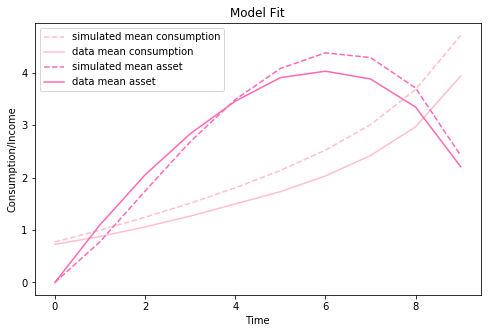

In [707]:
figure, axes = plt.subplots(figsize=(8,5)) 
axes.plot(range(T),c_mean, label='simulated mean consumption',linestyle='dashed', color='pink')
axes.plot(range(T),c_mean_data, label='data mean consumption', color='pink')
axes.plot(range(T),a_mean, label='simulated mean asset',linestyle='dashed',color='hotpink')
axes.plot(range(T),a_mean_data, label='data mean asset',color='hotpink')
axes.set_xlabel('Time')
axes.set_ylabel('Consumption/Income')
axes.set_title('Model Fit')
axes.legend()


## Standard error

Now compute the standard errors for estimators. First write Jacobian.

In [623]:
def Jacobian(g,θ):
    row = len(g(θ))
    col = len(θ)
    J = np.zeros([row, col])
    for i in range(len(θ)):
        ϵ = np.zeros_like(θ)
        ϵ[i] = 0.001*θ[i]
        J[:,i] = (g(θ+ϵ)-g(θ))/ϵ[i]
    return J
        

In [644]:
J = Jacobian(findMomentVec,θ_star)

In [645]:
S = 1  # number of simulation is 3000, so S=1
Σ = (1+1/S)*np.linalg.inv((J.T)@WeightMatrix@J)   

In [648]:
std = np.sqrt(np.diag(Σ))
std

array([0.11415645, 1.26665745])

Thus the standar error for $\hat{\beta}$ is 0.11 and the standard error for $\hat{\gamma}$ is 1.27

## Sensitivity

Apply the AGS formula to compute the sensitivity

In [627]:
Sensitivity = -(np.linalg.inv((J.T)@WeightMatrix@J))@(J.T)@WeightMatrix

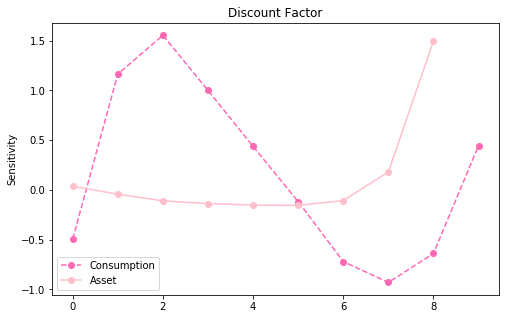

In [665]:
figure, axes = plt.subplots(figsize=(8,5)) 
axes.plot(range(10),Sensitivity[0,0:10], label='Consumption',linestyle='dashed', color='hotpink',marker='o')
axes.plot(range(9),Sensitivity[0,10:],label='Asset',color='pink',marker='o')
axes.set_ylabel('Sensitivity')
axes.set_title('Discount Factor')
axes.legend()

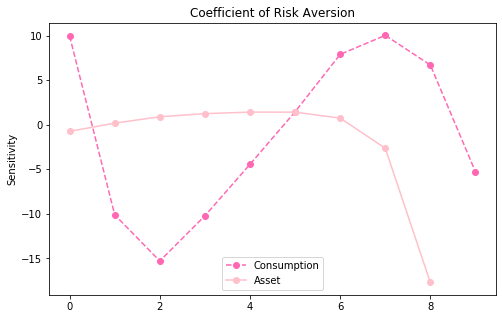

In [663]:
figure, axes = plt.subplots(figsize=(8,5)) 
axes.plot(range(10),Sensitivity[1,0:10], label='Consumption',linestyle='dashed', color='hotpink',marker='o')
axes.plot(range(9),Sensitivity[1,10:],label='Asset',color='pink', marker = 'o')
axes.set_ylabel('Sensitivity')
axes.set_title('Coefficient of Risk Aversion')
axes.legend()